In [1]:
import requests
import json
import os
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (17.,6.)})
sns.set_style("whitegrid")

In [283]:
te = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto2/temperature.csv')

In [5]:
nulls = [te[i].isna().value_counts() for i in te.columns]

In [6]:
print(nulls[2])

False    45252
True         1
Name: Portland, dtype: int64


### eliminamos columnas inecesarias (solo usa y canada)

In [268]:
def keep_columns(x, y):
    """
    Toma como argumento la lista de las columnas que quiero conservar y el nombre del data frame.
    Recorre el indice de columnas del data frame correspondiente y elimina las
    columnas que no quiero conservar
    """
    relevant = x
    for i in y.columns:
        if i not in relevant:
            y.drop(columns=[i], inplace=True)

In [301]:
keep_columns(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston'], te)

### Agrupamos por fecha y max

In [247]:
def agrup_mensual_max(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").max()

In [221]:
maximas = agrup_mensual_max(te)

In [222]:
keep_columns(['Vancouver', 'Portland', 'Los Angeles', 'Phoenix', 'Denver', 'Dallas', 'Houston', 'Minneapolis',
              'Saint Louis', 'Chicago', 'Atlanta', 'Detroit', 'Charlotte', 'Miami', 'Toronto', 'Philadelphia', 
              'New York', 'Montreal', 'Boston'], maximas)

In [223]:
def celsius_conv(row):
    for i in maximas.index:
           row[i] = row[i] - 273.15
    return row

In [224]:
tempmax = maximas.apply(lambda row : celsius_conv(row))

In [225]:
tempmax = tempmax.reset_index()

### Agrupamos por fecha y std

In [15]:
def agrup_mensual_std(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").std()

In [16]:
volat = agrup_mensual_std(te)

In [17]:
keep_columns(['Vancouver', 'Los Angeles', 'Denver', 'Houston', 'Chicago', 'Atlanta', 'Miami',
              'Toronto', 'New York', 'Montreal'], volat)

In [18]:
volat = volat.reset_index()

### Agrupamos por fecha y mediana

In [284]:
def agrup_mensual(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").median()

In [285]:
tem = agrup_mensual(te)

In [286]:
keep_columns(['Vancouver', 'Los Angeles', 'Denver', 'Houston', 'Chicago', 'Atlanta', 'Miami',
              'Toronto', 'New York', 'Montreal'], tem)

### transformamos a celsius

In [287]:
def celsius_conv(row):
    for i in tem.index:
           row[i] = row[i] - 273.15
    return row

In [288]:
temc = tem.apply(lambda row : celsius_conv(row))

In [289]:
temc = temc.reset_index()

In [ ]:
temc.head()

### Repetimos proceso con datos de humedad

In [181]:
h = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/Proyecto2/humidity.csv')

In [136]:
keep_columns(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston'], h)

In [137]:
hm = agrup_mensual(h)

In [138]:
hm = hm.reset_index()

### Variab hum vs co2

In [182]:
def agrup_mensual_std(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").std()

In [183]:
volath = agrup_mensual_std(h)

In [184]:
keep_columns(['Vancouver', 'Los Angeles', 'Denver', 'Houston', 'Chicago', 'Atlanta', 'Miami',
              'Toronto', 'New York', 'Montreal'], volath)

In [185]:
volath = volath.reset_index()

In [ ]:
volath.head(5)

### Obtengo los datos de la API

In [108]:
def get_carbon_data(url):
    url = f"{url}"
    headers = {
    'x-rapidapi-host': "daily-atmosphere-carbon-dioxide-concentration.p.rapidapi.com",
    'x-rapidapi-key': "6f91c81d8fmshc83b86b1b6c6c5cp108956jsnef221ca08c9a"
    }
    response = requests.request("GET", url, headers=headers)
    t = response.json()
    c = pd.DataFrame(t['co2'])
    return c

In [163]:
c = get_carbon_data('https://daily-atmosphere-carbon-dioxide-concentration.p.rapidapi.com/api/co2-api')

#### Creamos cd con todos los años para analizar dsp

In [91]:
def cod_agrupado(x):
    return x.groupby(["year", "month"]).agg({"cycle": "median"})

In [ ]:
cd = cod_agrupado(c)

#### Escalamos a cd para que tenga solo los años que nos interesan

In [164]:
dates = pd.period_range(start='2011-01-01', end='2021-08-28', freq='D')

In [165]:
c['datetime'] = [str(d) for d in dates]

In [166]:
keep_columns(['datetime', 'cycle'], c)

In [167]:
def agrup_mensual_co2(x):
    x['Date'] = x.datetime.apply(lambda y: y[:7])
    return x.groupby("Date").agg({"cycle": "median"})

In [168]:
co2 = agrup_mensual_co2(c)

In [169]:
co2 = co2.reset_index()

#### CHPPED CO2

In [170]:
cco2 = agrup_mensual_co2(c)

In [171]:
cco2 = cco2.reset_index()

In [172]:
for i in range(83, 128):
    cco2.drop([i], axis=0, inplace=True)
for i in range(21):
    cco2.drop([i], axis=0, inplace=True)

### Unimos temperatura con carbono

In [291]:
tyc = temc.set_index('Date').join(co2.set_index('Date'))

In [292]:
tyc = tyc.reset_index()

In [293]:
tyc.head()

,Date,Vancouver,Los Angeles,Denver,Houston,Chicago,Atlanta,Miami,Toronto,New York,Montreal,cycle
0,2012-10,10.050,19.260,9.730,21.960,10.390,16.080,26.250000,10.110,14.7500,10.600000,391.910
1,2012-11,7.165,15.500,7.190,17.465,4.885,9.395,21.660000,3.550,5.6950,1.255000,393.825
2,2012-12,4.025,13.245,0.275,17.255,2.455,9.935,22.190000,0.750,4.4900,-3.135000,394.810
3,2013-01,2.410,11.585,-0.535,11.930,-2.380,8.890,22.485000,-1.110,2.0150,-8.603625,395.500
4,2013-02,5.190,12.135,-1.660,15.060,-2.290,7.125,21.997867,-3.645,0.1725,-7.500000,396.255


### Unimos humedad con carbono

In [139]:
hyc = hm.set_index('Date').join(co2.set_index('Date'))

In [140]:
hyc = hyc.reset_index()

### GRAFICOS

### No hay un claro aumento de temp por aumento de co2 para este data set

<ipython-input-239-93ef3071cb36>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.lineplot(x="Date", y="Los Angeles", data=temc, ax=axs[4]).set_xticklabels(labels=temc["Date"], rotation=60);


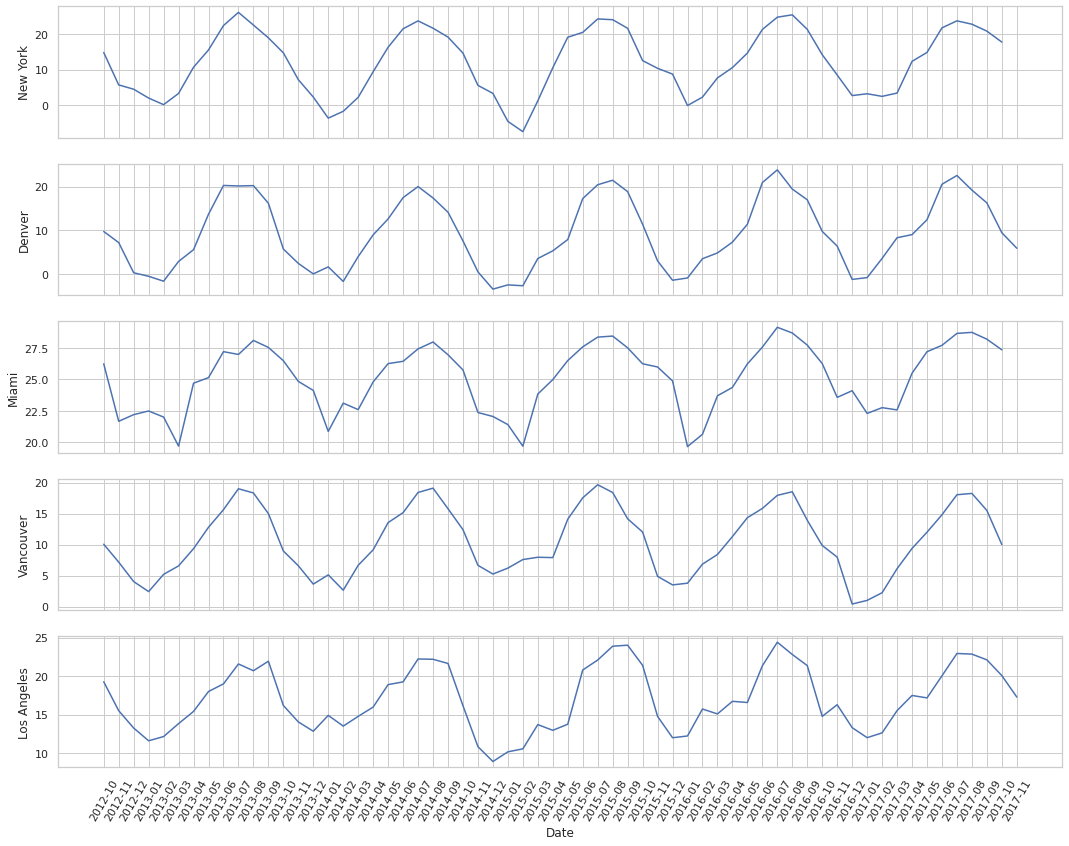

In [239]:
fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(18, 14))
sns.lineplot(x="Date", y="New York", data=temc, ax=axs[0])
sns.lineplot(x="Date", y="Denver", data=temc, ax=axs[1])
sns.lineplot(x="Date", y="Miami", data=temc, ax=axs[2])
sns.lineplot(x="Date", y="Vancouver", data=temc, ax=axs[3])
sns.lineplot(x="Date", y="Los Angeles", data=temc, ax=axs[4]).set_xticklabels(labels=temc["Date"], rotation=60);

### CO2 OVER TIME (MODIFICAR X LABEL)

<ipython-input-240-97cb50a66bad>:1: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.lineplot(data=co2, x="Date", y="cycle").set_xticklabels(labels=co2["Date"], rotation=75);


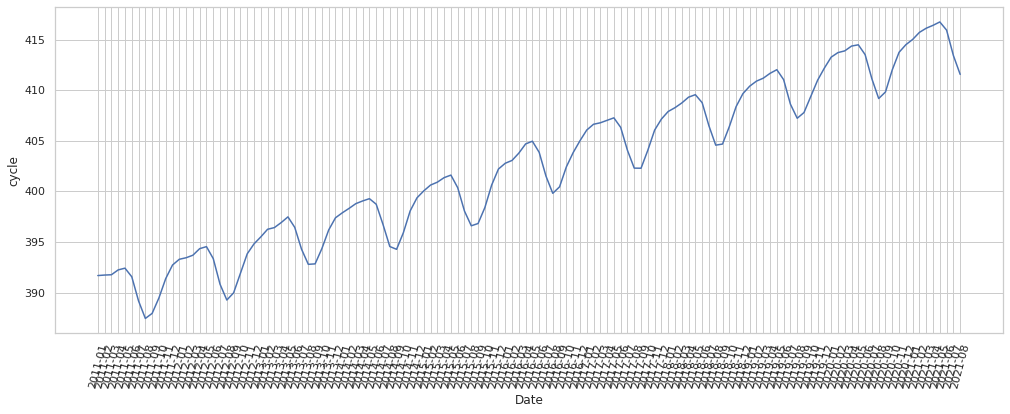

In [240]:
sns.lineplot(data=co2, x="Date", y="cycle").set_xticklabels(labels=co2["Date"], rotation=75);

### CO2 OVER TIME CON TEMPS

<ipython-input-64-7adf0d4c1460>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.scatterplot(x="Date", y="cycle", hue="Los Angeles", data=tyc, ax=axs[2]).set_xticklabels(labels=tyc["Date"], rotation=60);


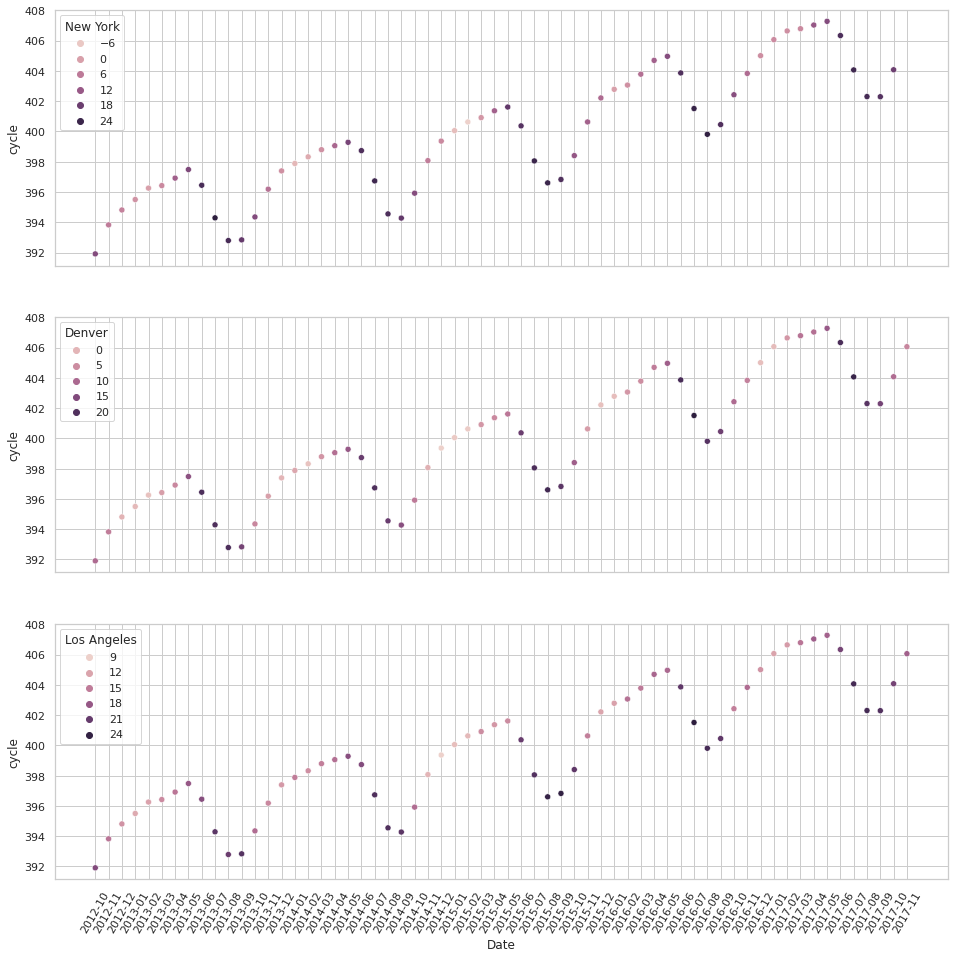

In [64]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(16, 16))
sns.scatterplot(x="Date", y="cycle", hue="New York", data=tyc, ax=axs[0])
sns.scatterplot(x="Date", y="cycle", hue="Denver", data=tyc, ax=axs[1])
sns.scatterplot(x="Date", y="cycle", hue="Los Angeles", data=tyc, ax=axs[2]).set_xticklabels(labels=tyc["Date"], rotation=60);

<AxesSubplot:>

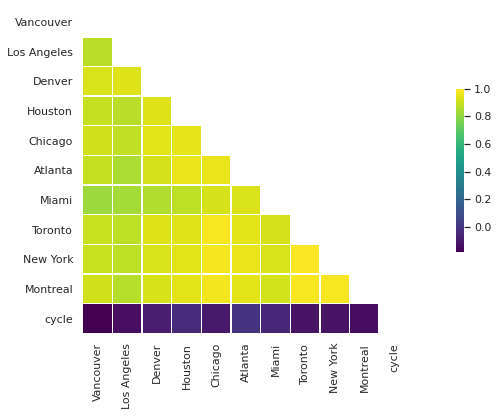

In [297]:
tro = tyc.corr()
mascara = np.triu(np.ones_like(tro, dtype=bool)) # generamos la máscara para la triangular superior
color_map = sns.diverging_palette(0, 10, as_cmap=True) # paleta de colores


sns.heatmap(tro, 
            mask=mascara,
            cmap="viridis",
            vmax=1,
            square=True, 
            linewidth=.5, 
            cbar_kws={"shrink": .5})

#### Se puede ver que si bien la tendencia del nivel de co2 es postiva, hay un cicloestacional, en invierno los niveles de co2 aumentan y en verano descienden. Se puede ver reflejado en el heat map de correlaciones, la corr entre el co2 y las tem, es negativa. Esto nos muestra el pulso de la respiración de los bosques en norteamerica, en otoño invierno los arboles disminuyen la absorción de co2, y en primavera verano, aumenta. 

### Variabilidad temp vs co2

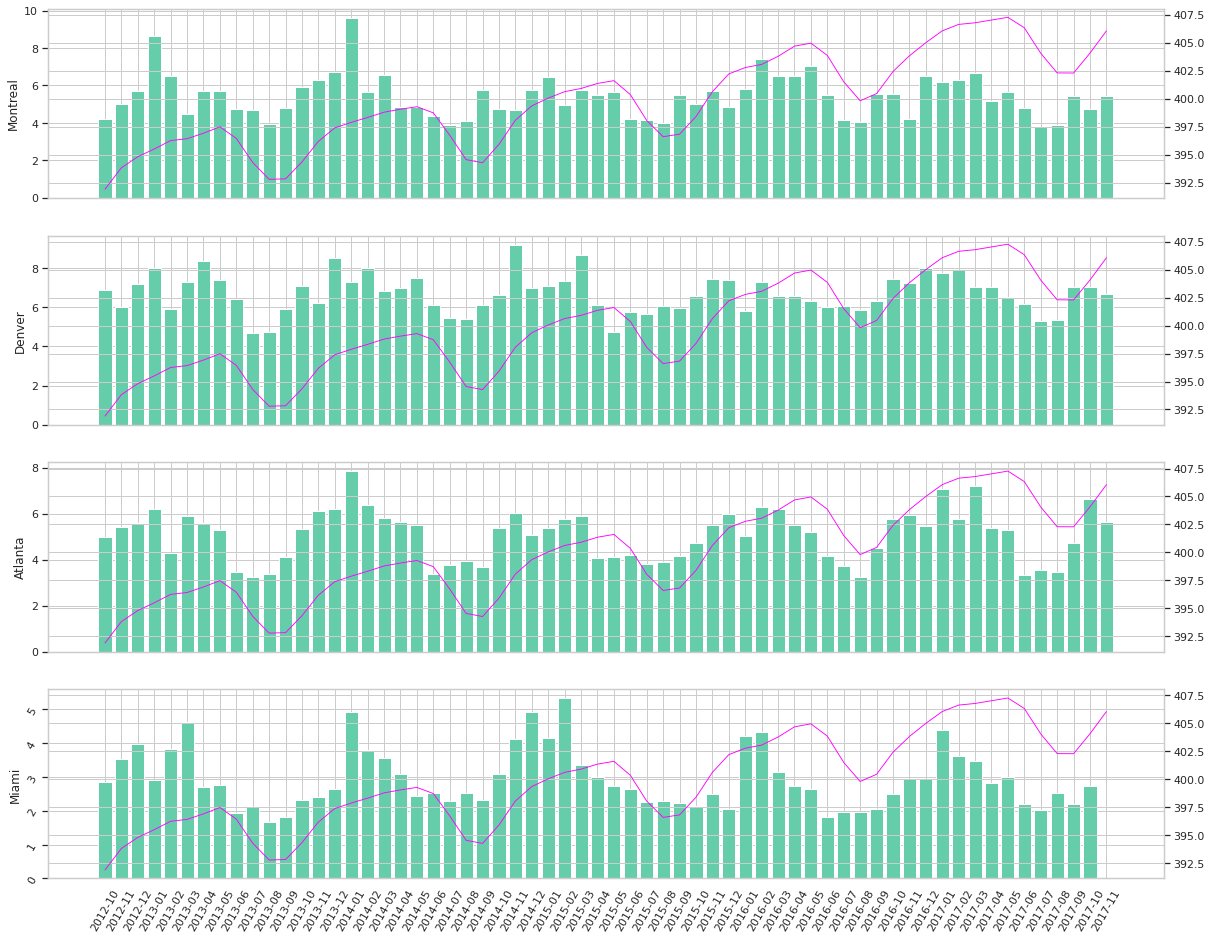

In [179]:
fig, ((x1, x2, x3, x4)) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 16))

x1.bar(volat.Date, volat.Montreal, color="mediumaquamarine")
x1.set_ylabel('Montreal')
x2.bar(volat.Date, volat.Denver, color="mediumaquamarine")
x2.set_ylabel('Denver')
x3.bar(volat.Date, volat.Atlanta, color="mediumaquamarine")
x3.set_ylabel('Atlanta')
x4.bar(volat.Date, volat.Miami, color="mediumaquamarine")
x4.set_ylabel('Miami')

b = x1.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

b = x2.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

b = x3.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

b = x4.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="fuchsia")

x4.tick_params(labelrotation=60);

### Variabilidad hume vs co2

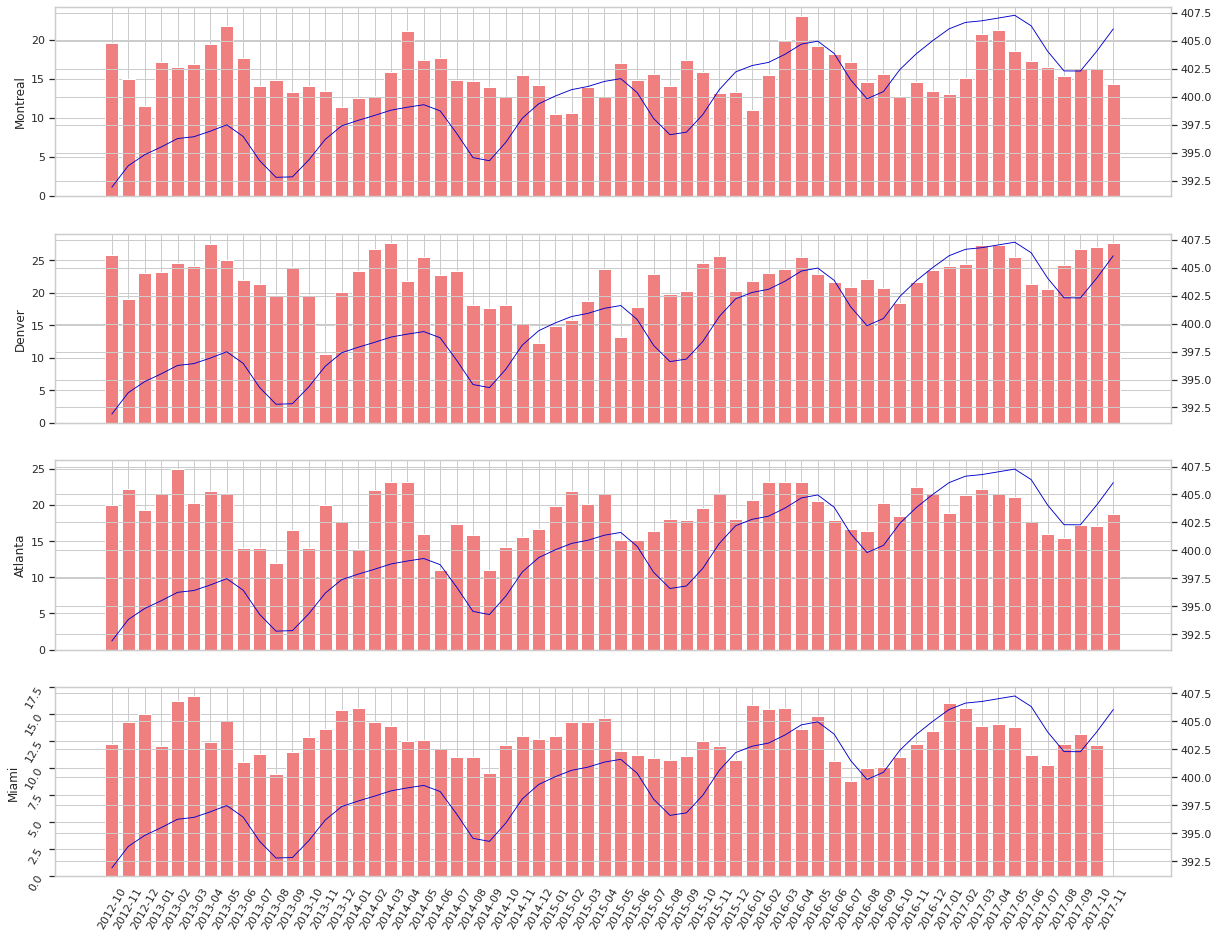

In [187]:
fig, ((x1, x2, x3, x4)) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20, 16))

x1.bar(volath.Date, volath.Montreal, color="lightcoral")
x1.set_ylabel('Montreal')
x2.bar(volath.Date, volath.Denver, color="lightcoral")
x2.set_ylabel('Denver')
x3.bar(volath.Date, volath.Atlanta, color="lightcoral")
x3.set_ylabel('Atlanta')
x4.bar(volath.Date, volath.Miami, color="lightcoral")
x4.set_ylabel('Miami')

b = x1.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

b = x2.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

b = x3.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

b = x4.twinx()
b.plot(cco2.Date, cco2.cycle, linewidth = 0.9, color="mediumblue")

x4.tick_params(labelrotation=60);

#### La relacion entre el aumento co2  y el de temperatura y humedad, no se ven reflejados en este data set, creo porque la ventana temporal es corta y hace refrencia solo a canada y eeuu. Sin embargo si podemos observar la como la variabilidad aumento, cuando aumentan los niveles de co2.